# Analyzing Trump's Tweets Using BERT

* [Tutorial1](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) Part of this is broken

* [Tutorial2](https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671)

In [1]:
%cd C:\Users\tenis\OneDrive\Desktop\Data_Projects\presidential_tweets_sentiment_analysis
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 27
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\tenis\OneDrive\Desktop\Data_Projects\presidential_tweets_sentiment_analysis


In [ ]:
#df = pd.read_csv("data/interim/df_with_basic_sentiment.csv")
#df = df.rename(columns={"Sentiment": "basic_sentiment"})
#df.head()

In [2]:
df = pd.read_csv("data/external/reviews.csv")

In [3]:
df.shape

(15746, 11)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


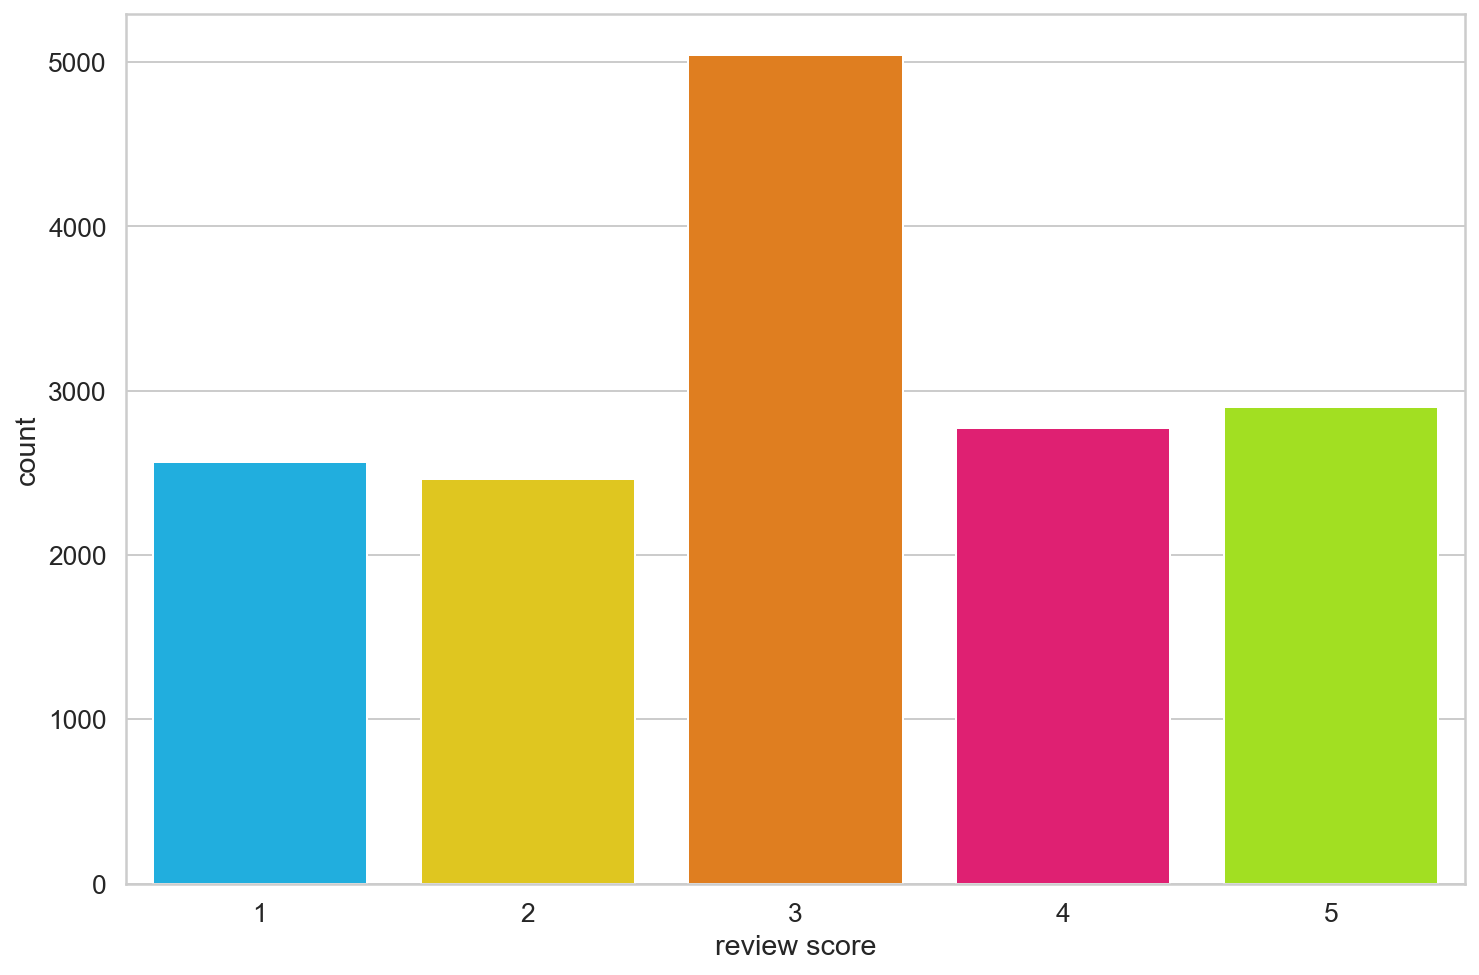

In [5]:
sns.countplot(df.score)
plt.xlabel('review score');

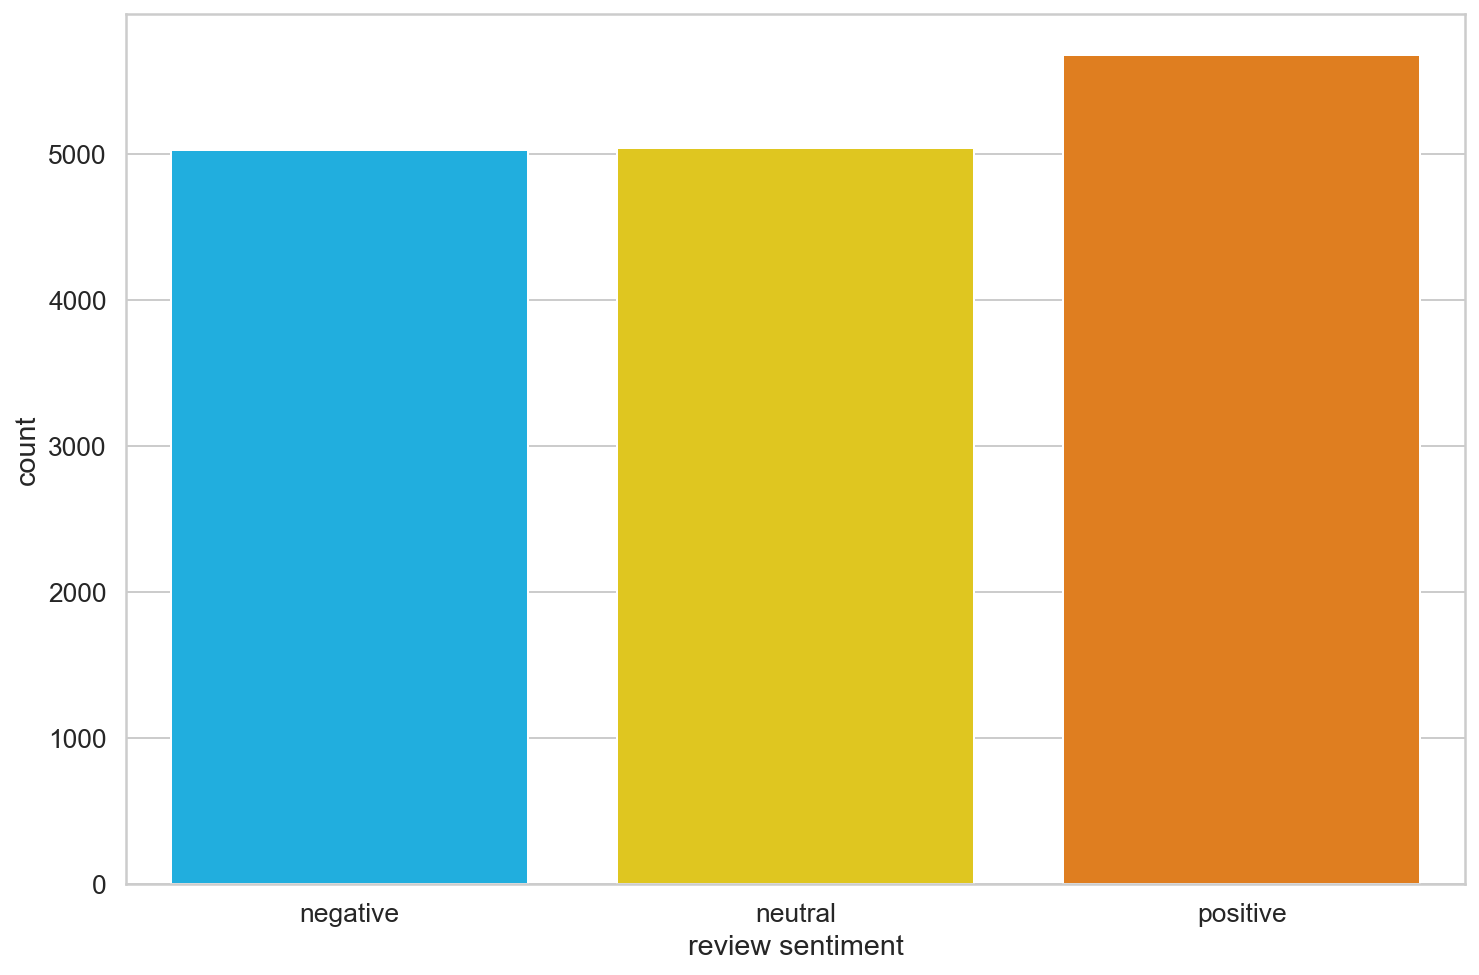

In [6]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2
df['sentiment'] = df.score.apply(to_sentiment)

class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [7]:
#Setting the type of transformer. In this case, "cased sensitive" BERT
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [8]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Example

In [9]:
sample_tweet = 'People are forgetting that if Sleepy Joe Biden and the Radical Left Dems win you will very quickly lose your Second Amendment!'

In [10]:
tokens = tokenizer.tokenize(sample_tweet)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_tweet}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: People are forgetting that if Sleepy Joe Biden and the Radical Left Dems win you will very quickly lose your Second Amendment!
   Tokens: ['People', 'are', 'forgetting', 'that', 'if', 'Sleep', '##y', 'Joe', 'B', '##iden', 'and', 'the', 'Radical', 'Left', 'De', '##ms', 'win', 'you', 'will', 'very', 'quickly', 'lose', 'your', 'Second', 'Amendment', '!']
Token IDs: [2563, 1132, 20608, 1115, 1191, 15153, 1183, 2658, 139, 26859, 1105, 1103, 20411, 8123, 3177, 4206, 1782, 1128, 1209, 1304, 1976, 3857, 1240, 2307, 10060, 106]


# Special Tokens

In [11]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [12]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [13]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [14]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [15]:
encoding = tokenizer.encode_plus(
  sample_tweet,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [16]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2563,  1132, 20608,  1115,  1191, 15153,  1183,  2658,   139,
        26859,  1105,  1103, 20411,  8123,  3177,  4206,  1782,  1128,  1209,
         1304,  1976,  3857,  1240,  2307, 10060,   106,   102,     0,     0,
            0,     0])

In [17]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0]])

In [18]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'People',
 'are',
 'forgetting',
 'that',
 'if',
 'Sleep',
 '##y',
 'Joe',
 'B',
 '##iden',
 'and',
 'the',
 'Radical',
 'Left',
 'De',
 '##ms',
 'win',
 'you',
 'will',
 'very',
 'quickly',
 'lose',
 'your',
 'Second',
 'Amendment',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [20]:
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

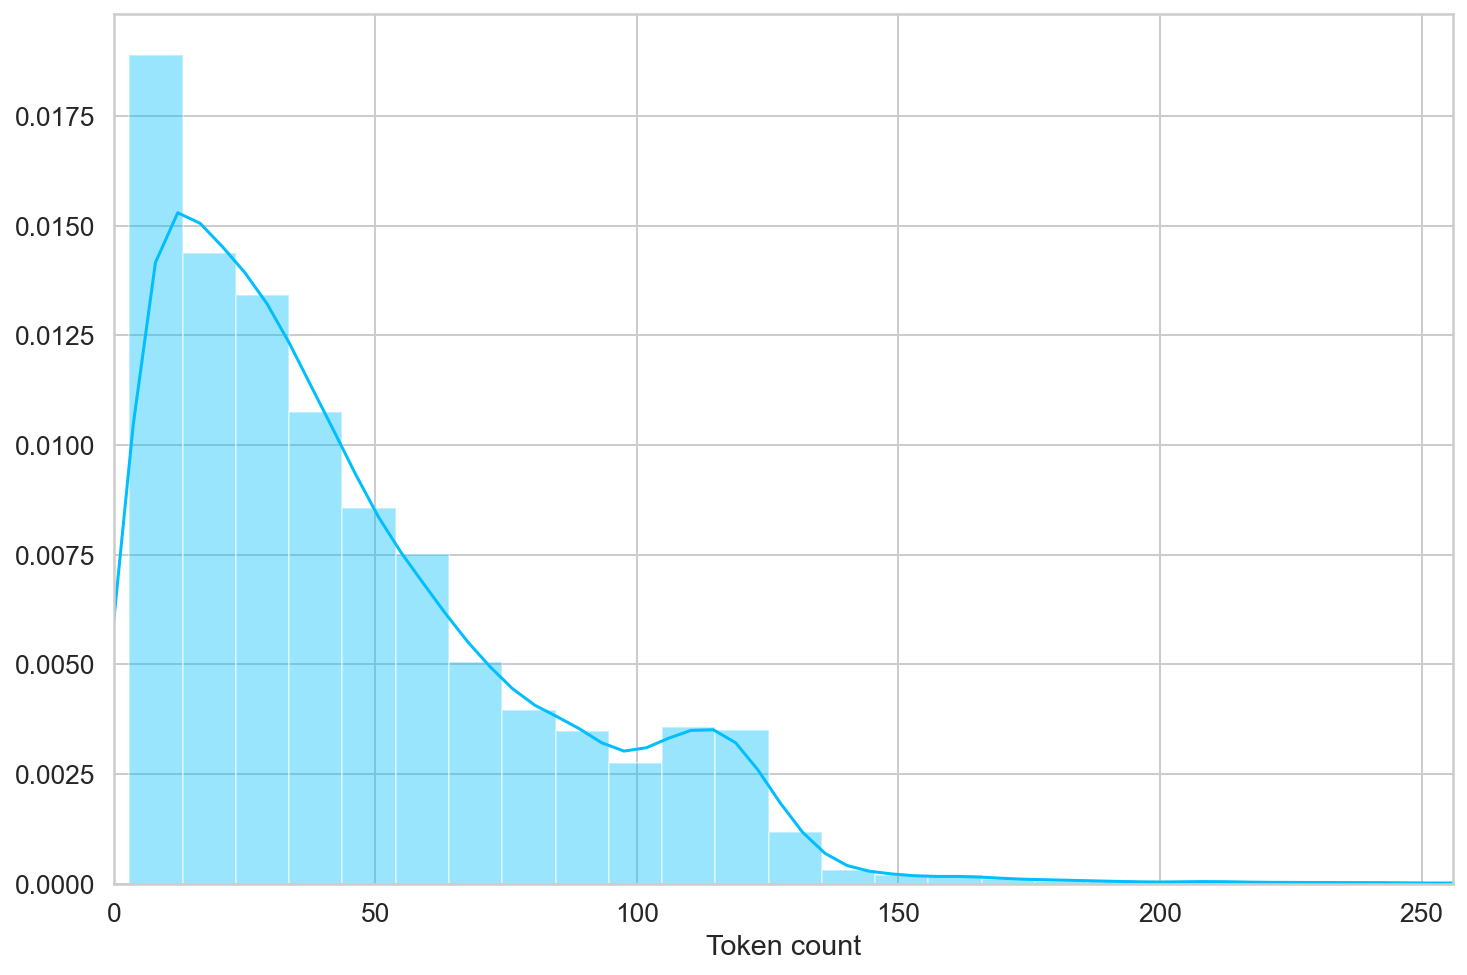

In [21]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [22]:
MAX_LEN = 160

In [23]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

# Train Test for Validation 

In [24]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [25]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [26]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [27]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
from tqdm import tqdm

data = next(tqdm(iter(train_data_loader)))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)